In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['to'])
simulation.update_bc_val(gridx, gridy, 'velc_prev', scalars.variable['to'])

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

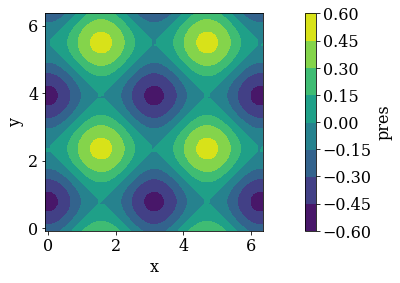

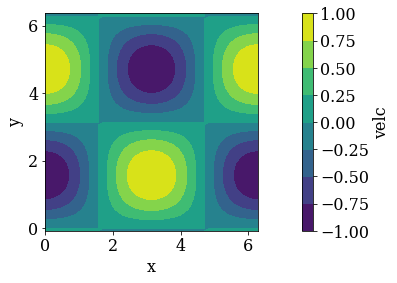

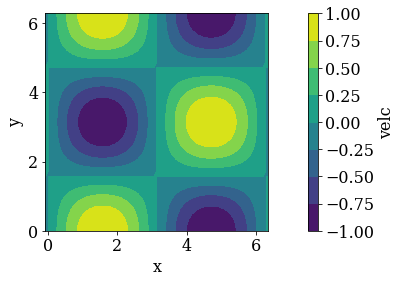

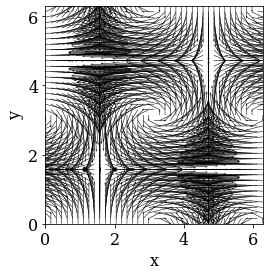

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

#1st iteration with Euler explicit scheme

# Predictor Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

# Divergence Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

# Solve the pressure Poisson equation 
scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                                    poisson_options)
# Corrector Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

# Display stats
if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   

scalars.advance()

while scalars.variable['time'] <= scalars.variable['tmax']:
        
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.variable['time'])
    simulation.update_bc_val(gridx, gridy, 'velc_prev', scalars.variable['time'])
        
    # Predictor Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

    # Divergence Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                                        poisson_options)
    # Corrector Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   

    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.972981176514638e-13
Max, Min, U   : 0.9969173337331281, -0.996917333733128
Max, Min, V   : 0.996917333733128, -0.9969173337331281
Max, Min, P   : 1.8727542255516239, -1.0886441947452268
Max, Min, DIV : 7.216449660063518e-16, -7.771561172376096e-16


------------ Time = 0.010000000000000002 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.677508477383397e-13
Max, Min, U   : 0.9771770479217199, -0.9771770479217198
Max, Min, V   : 0.9771770479217198, -0.9771770479217199
Max, Min, P   : 0.855476399448248, -0.08937653678421334
Max, Min, DIV : 7.771561172376096e-16, -7.771561172376096e-16


------------ Time = 0.02000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 5.195469753195826e-13
Max, Min, U   : 0.9578276459586815, -0.9578276459586814
Max, Min, V   : 0.9578276459586814, -0.9578276459586815
Max, Min, P   :

------------ Time = 0.3900000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.063248022900053e-13
Max, Min, U   : 0.45699289855764136, -0.4569928985576413
Max, Min, V   : 0.4569928985576413, -0.45699289855764136
Max, Min, P   : -0.19214471941752556, -0.3989624513509523
Max, Min, DIV : 3.608224830031759e-16, -4.163336342344337e-16


------------ Time = 0.4000000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.3166433304524426e-13
Max, Min, U   : 0.44794383287680867, -0.4479438328768086
Max, Min, V   : 0.4479438328768086, -0.44794383287680867
Max, Min, P   : -0.2335869534564757, -0.43229658874551163
Max, Min, DIV : 3.608224830031759e-16, -3.608224830031759e-16


------------ Time = 0.4100000000000003 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.370028426586823e-13
Max, Min, U   : 0.4390739507017907, -0.43907395070179067
Max, Min, V   : 0.43907395070179067, -0.4390739

------------ Time = 0.7700000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.1981654754239457e-13
Max, Min, U   : 0.2138855659454319, -0.21388556594543184
Max, Min, V   : 0.2138855659454319, -0.2138855659454319
Max, Min, P   : -0.09050559972355555, -0.13583999540451872
Max, Min, DIV : 2.220446049250313e-16, -1.942890293094024e-16


------------ Time = 0.7800000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 4.777005791507795e-13
Max, Min, U   : 0.20965696047989182, -0.20965696047989182
Max, Min, V   : 0.20965696047989185, -0.20965696047989185
Max, Min, P   : -0.4534743063740871, -0.49703433487093995
Max, Min, DIV : 1.942890293094024e-16, -1.942890293094024e-16


------------ Time = 0.7900000000000006 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.3215992154117305e-13
Max, Min, U   : 0.20551198398915133, -0.20551198398915133
Max, Min, V   : 0.20551198398915133, -0.205

------------ Time = 1.1499999999999841 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.914217744537227e-14
Max, Min, U   : 0.1001590775821547, -0.10015907758215468
Max, Min, V   : 0.10015907758215467, -0.10015907758215468
Max, Min, P   : 0.03226627422957193, 0.022317491354469674
Max, Min, DIV : 9.020562075079397e-17, -9.020562075079397e-17


------------ Time = 1.159999999999983 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.2763355587632295e-14
Max, Min, U   : 0.09817959253728457, -0.09817959253728456
Max, Min, V   : 0.09817959253728456, -0.09817959253728456
Max, Min, P   : 0.036241960501777595, 0.026682266451599077
Max, Min, DIV : 9.020562075079397e-17, -9.71445146547012e-17


------------ Time = 1.169999999999982 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.618663502402198e-14
Max, Min, U   : 0.09623925160077766, -0.09623925160077766
Max, Min, V   : 0.09623925160077765, -0.09623

------------ Time = 1.5099999999999445 ---------------
Number of poisson iterations    : None
Final poisson residual : 6.917289503927183e-14
Max, Min, U   : 0.0488286407665741, -0.0488286407665741
Max, Min, V   : 0.0488286407665741, -0.0488286407665741
Max, Min, P   : -0.06420657155947324, -0.06657369739160812
Max, Min, DIV : 4.85722573273506e-17, -4.85722573273506e-17


------------ Time = 1.5199999999999434 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.8458523263082594e-15
Max, Min, U   : 0.047864095124551344, -0.04786409512455134
Max, Min, V   : 0.047864095124551344, -0.047864095124551344
Max, Min, P   : -0.0015163105412334759, -0.0037909041454639923
Max, Min, DIV : 4.5102810375396984e-17, -4.5102810375396984e-17


------------ Time = 1.5299999999999423 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.918779273394234e-14
Max, Min, U   : 0.046918617730594026, -0.046918617730594026
Max, Min, V   : 0.04691861773059403

------------ Time = 1.8799999999999037 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.170876560939796e-15
Max, Min, U   : 0.02334414415183865, -0.02334414415183865
Max, Min, V   : 0.02334414415183865, -0.02334414415183865
Max, Min, P   : -0.00853288155716552, -0.009074294703544998
Max, Min, DIV : 2.2551405187698492e-17, -2.2551405187698492e-17


------------ Time = 1.8899999999999026 ---------------
Number of poisson iterations    : None
Final poisson residual : 5.30044527884644e-15
Max, Min, U   : 0.02288331853148398, -0.022883318531483985
Max, Min, V   : 0.02288331853148398, -0.02288331853148398
Max, Min, P   : 0.0058156905402184395, 0.005295436618453674
Max, Min, DIV : 2.2551405187698492e-17, -2.2551405187698492e-17


------------ Time = 1.8999999999999015 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.710503525249684e-14
Max, Min, U   : 0.02243159912458534, -0.022431599124585335
Max, Min, V   : 0.0224315991245853

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.variable['time'])

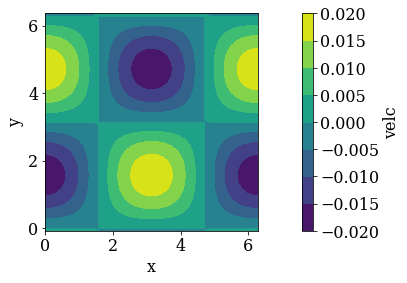

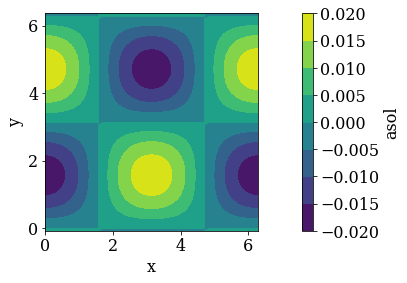

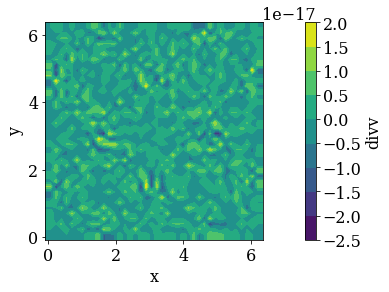

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divv')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

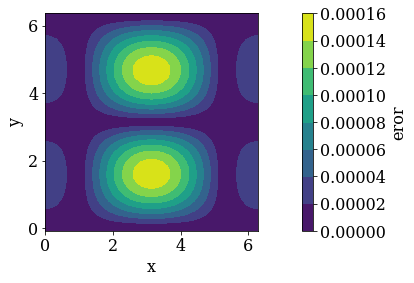

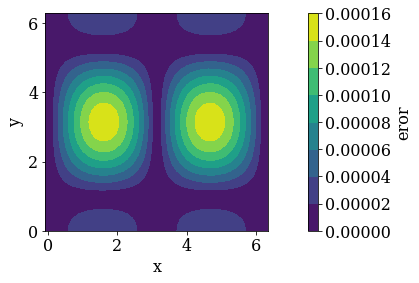

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')